In [2]:
import numpy as np
import pandas as pd
import os
from datetime import timedelta

from grid_and_bathy import get_grid
from configs.config_object import ConfigObject

In [3]:
config = ConfigObject('../config.json')

In [4]:
time_resolution = timedelta(hours=1)

In [5]:
path_grid = config.paths.grid_folder_path
output_folder = '../99-output/binary_data/'
grid_resolution = config.grid_resolution
weather_model=config.weather_model
start_date=config.start_date
end_date=config.end_date
weather_model_type=config.weather_model_type

path_out = os.path.join(output_folder, rf'input_mitgcm_{weather_model}_{start_date}_{end_date}_{grid_resolution}m')

In [6]:
mitgcm_grid = get_grid(path_grid)

# Get binary files characteristics

In [7]:
nx = len(mitgcm_grid.x)
ny = len(mitgcm_grid.y)
nt = (pd.to_datetime(end_date, format="%Y%m%d") - pd.to_datetime(start_date, format="%Y%m%d")) / time_resolution +1

In [8]:
base_arr = np.zeros((int(nt),int(ny),int(nx)))

# Wind

In [9]:
u10 = base_arr.copy()
wind_duration_in_hours = 24
wind_intensity = -10
u10[:wind_duration_in_hours,:,:] = wind_intensity

In [10]:
# Stop the main heat input after the wind stops to avoid temperature skyrocketing
swdown = (base_arr.copy()+1) * 250
lwdown = (base_arr.copy()+1) * 350
swdown[wind_duration_in_hours+1:,:,:] = 150
lwdown[wind_duration_in_hours+1:,:,:] = 300

# Constant values for other external forcings

In [11]:
v10 = base_arr.copy()
apressure = (base_arr.copy()+1) * 96653
atemp = (base_arr.copy()+1) * 293
aqh = (base_arr.copy()+1) * 0.011

# Save binary files

In [12]:
def write_array_to_binary(path_fname, data):
    dtype = '>f8'  # big-endian and precision 64 (small-endian with precision 32 is '<f4')
    data = data.astype(dtype)

    # Write to file
    fid = open(path_fname, 'wb')
    data.tofile(fid)
    fid.close()

In [13]:
write_array_to_binary(os.path.join(output_folder, 'u10.bin'), u10)
write_array_to_binary(os.path.join(output_folder, 'v10.bin'), v10)
write_array_to_binary(os.path.join(output_folder, 'swdown.bin'), swdown)
write_array_to_binary(os.path.join(output_folder, 'lwdown.bin'), lwdown)
write_array_to_binary(os.path.join(output_folder, 'apressure.bin'), apressure)
write_array_to_binary(os.path.join(output_folder, 'atemp.bin'), atemp)
write_array_to_binary(os.path.join(output_folder, 'aqh.bin'), aqh)

# Check bin files

In [19]:
import matplotlib.pyplot as plt

In [61]:
with open(os.path.join(output_folder, 'aqh.bin'), 'rb') as fid:
    binary_data = np.fromfile(fid, dtype='>f8')

In [62]:
nt, ny, nx = base_arr.shape

In [63]:
bin_arr = np.reshape(binary_data, (int(nt),int(ny),int(nx)))

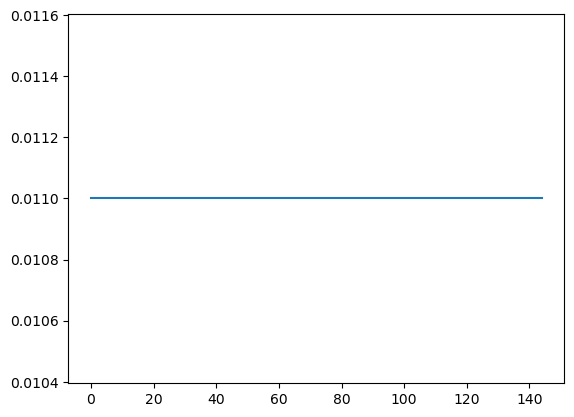

In [64]:
plt.plot(bin_arr[:,50,50])